In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, roc_auc_score, confusion_matrix, classification_report, cohen_kappa_score

from sklearn import ensemble, tree
from xgboost import XGBClassifier

from jupyterthemes import jtplot
jtplot.style(theme = "monokai", context = "notebook", ticks = True, grid = False)

In [3]:
data = pd.read_csv("Churnscore Inputdata F-IT.csv", header = 0, index_col=0, sep = ";")
data.head(5)

,month_n,cust_age,sales_net_eur,sales_net_eur_1,sales_net_eur_2,sales_net_eur_3,sales_net_eur_4,sales_net_eur_5,sales_net_eur_6,sales_net_eur_7,...,trend_1_increase,rev_0_grp,segment_24,rev_0_count,rev_not_0_count,turn_behav_counter,trend_counter,churn_36,prediction,prediction_01
rowid,,,,,,,,,,,,,,,,,,,,,
1,1,-1,0,0,0,0,0,0,0,0,...,0,1,1,16,0,5,5,1,"0,97725",1
2,1,0,"269,82",0,0,0,0,0,0,0,...,0,0,3,0,1,1,1,0,"0,98967",1
3,1,0,"1070,93",0,0,0,0,0,0,0,...,0,0,3,0,1,1,1,0,"0,17243",0
4,1,0,"2880,20997",0,0,0,0,0,0,0,...,0,0,3,0,1,1,1,0,"0,20407",0
5,1,0,"20513,6299",0,0,0,0,0,0,0,...,0,0,3,0,1,1,1,0,"-0,09169",0


In [4]:
%%time
for col in data.columns:
        col_type = data[col].dtype
        if col_type != 'int64':
            data[col] = [re.sub(",", ".", str(x)) for x in data[col]]
            data[col] = data[col].astype(np.float64)
    
data.dtypes

Wall time: 5.75 s


month_n                 int64
cust_age                int64
sales_net_eur         float64
sales_net_eur_1       float64
sales_net_eur_2       float64
                       ...   
turn_behav_counter      int64
trend_counter           int64
churn_36                int64
prediction            float64
prediction_01           int64
Length: 180, dtype: object

In [5]:
df = data[data.segment_24 > 1].copy()
# df = data[data.segment_24 == 1].copy()

df.info()
print('-'*70)
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8789 entries, 2 to 76160
Columns: 180 entries, month_n to prediction_01
dtypes: float64(47), int64(133)
memory usage: 12.1 MB
----------------------------------------------------------------------


,month_n,cust_age,sales_net_eur,sales_net_eur_1,sales_net_eur_2,sales_net_eur_3,sales_net_eur_4,sales_net_eur_5,sales_net_eur_6,sales_net_eur_7,...,trend_1_increase,rev_0_grp,segment_24,rev_0_count,rev_not_0_count,turn_behav_counter,trend_counter,churn_36,prediction,prediction_01
rowid,,,,,,,,,,,,,,,,,,,,,
2,1,0,269.82000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,3.0,0,1,1,1,0,0.98967,1
3,1,0,1070.93000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,3.0,0,1,1,1,0,0.17243,0
4,1,0,2880.20997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,3.0,0,1,1,1,0,0.20407,0
5,1,0,20513.62990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,3.0,0,1,1,1,0,-0.09169,0
7,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,3.1,11,0,12,12,1,1.09701,1
8,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,3.1,11,0,12,12,1,1.12880,1
9,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,3.1,10,0,11,11,1,0.93858,1
10,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,3.1,9,0,10,10,1,0.97132,1
11,1,1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,3.1,9,0,10,10,0,0.36822,0


In [6]:
# Separating target column from other features
target = 'churn_36'
y = df[target]
x = df.drop(columns = target)

x.drop(columns = ['prediction', 'prediction_01'], inplace = True)
x.drop(columns = x.filter(regex=("salesorg*")), inplace = True)

In [7]:
# Train and Test dataset split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify = y)

Best Hyper Parameters: {'max_depth': 6, 'n_estimators': 100, 'random_state': 42}
AUC: 0.790
RF accuracy: 0.723


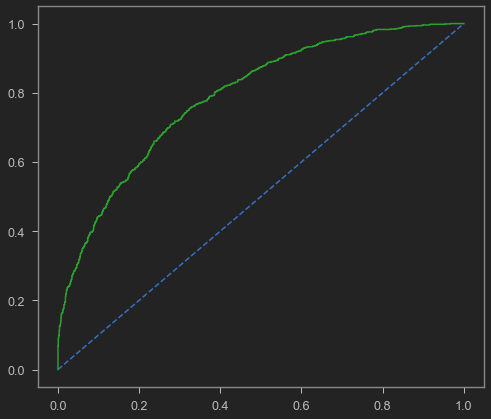

Wall time: 4.7 s


In [8]:
%%time
# random forest model hyper-tuned
RF = ensemble.RandomForestClassifier()
params = {
          'n_estimators':[n for n in range(50, 150, 50)], #100
          'max_depth':[n for n in range(4, 8, 2)], #6
#           'min_samples_leaf': [4,5],
#           'bootstrap': [False, True],
#           'max_features' : ['sqrt', 'log2']
          'random_state' : [42]
          }

RF_model = GridSearchCV(RF, param_grid = params, cv = 5, n_jobs = -1).fit(x_train, y_train)
print("Best Hyper Parameters:",RF_model.best_params_)

# Area under the curve probability score
RF_probs = RF_model.predict_proba(x_test)
RF_probs = RF_probs[:, 1]
RF_auc = roc_auc_score(y_test, RF_probs)
print('AUC: %.3f' % RF_auc)

RF_predictions = RF_model.predict(x_test)
RF_accuracy = accuracy_score(y_test, RF_predictions)
print("RF accuracy: %.3f" % RF_accuracy)

# AUC plot
RF_fpr, RF_tpr, RF_thresholds = roc_curve(y_test, RF_probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(RF_fpr, RF_tpr, color = 'tab:green')
plt.show()

Best Hyper Parameters: {'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 250, 'random_state': 42}
AUC: 0.962
GBT accuracy: 0.908


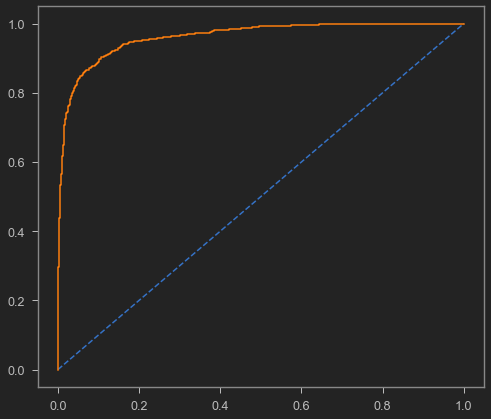

Wall time: 2min 53s


In [9]:
%%time
# gradient boosting tree model hyper-tuned

GBT = ensemble.GradientBoostingClassifier()
params = {
          'n_estimators':[n for n in range(200, 300, 50)], #200
          'max_depth':[n for n in range(8, 10, 2)], #8
          'learning_rate': [0.1, 0.25, 0.5],
          #'min_samples_leaf': [1,2,3,4],
          'random_state' : [42],
          #'loss' : ['deviance', 'exponential']
          }

GBT_model = GridSearchCV(GBT, param_grid = params, cv = 7, n_jobs = -1)
GBT_model.fit(x_train, y_train)
print("Best Hyper Parameters:",GBT_model.best_params_)

# Area under the curve probability score
GBT_probs = GBT_model.predict_proba(x_test)
GBT_probs = GBT_probs[:, 1]
GBT_auc = roc_auc_score(y_test, GBT_probs)
print('AUC: %.3f' % GBT_auc)

GBT_predictions = GBT_model.predict(x_test)
GBT_accuracy = accuracy_score(y_test, GBT_predictions)
print("GBT accuracy: %.3f" % GBT_accuracy)

# AUC plot
GBT_fpr, GBT_tpr, GBT_thresholds = roc_curve(y_test, GBT_probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(GBT_fpr, GBT_tpr, color = 'tab:orange')
plt.show()

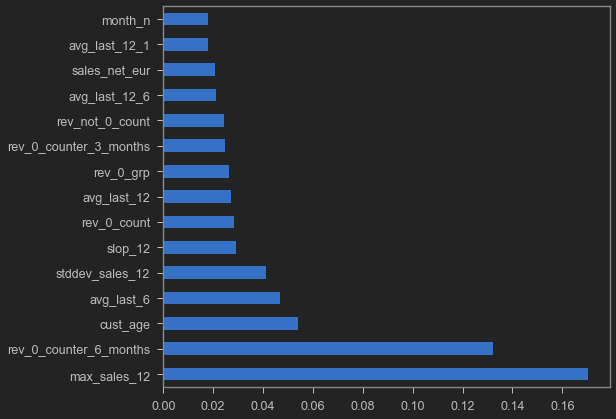

In [10]:
pd.Series(GBT_model.best_estimator_.feature_importances_, index=x.columns).nlargest(15).plot(kind='barh')
plt.show()

In [11]:
print("GBT cohen_kappa_score: %.3f" % cohen_kappa_score(y_test, GBT_predictions))
#The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

GBT cohen_kappa_score: 0.802


In [12]:
df['prediction_grmk'] = GBT_model.best_estimator_.predict(df[x_test.columns])

df['probability_grmk'] = GBT_model.best_estimator_.predict_proba(df[x_test.columns])[:,1]
df['probability_grmk'] = df['probability_grmk'].round(3)

df

,month_n,cust_age,sales_net_eur,sales_net_eur_1,sales_net_eur_2,sales_net_eur_3,sales_net_eur_4,sales_net_eur_5,sales_net_eur_6,sales_net_eur_7,...,segment_24,rev_0_count,rev_not_0_count,turn_behav_counter,trend_counter,churn_36,prediction,prediction_01,probability_grmk,prediction_grmk
rowid,,,,,,,,,,,,,,,,,,,,,
2,1,0,269.82000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,...,3.0,0,1,1,1,0,0.98967,1,0.009,0
3,1,0,1070.93000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,...,3.0,0,1,1,1,0,0.17243,0,0.011,0
4,1,0,2880.20997,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,...,3.0,0,1,1,1,0,0.20407,0,0.096,0
5,1,0,20513.62990,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,...,3.0,0,1,1,1,0,-0.09169,0,0.001,0
7,1,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00,...,3.1,11,0,12,12,1,1.09701,1,0.999,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75933,12,18,888.41000,3371.08998,0.00000,0.00000,0.00000,0.0,0.00000,0.00,...,2.1,0,2,2,2,1,1.14129,1,0.969,1
75999,12,18,2077.89001,717.34999,3920.39000,2480.32998,58.90000,44.9,3927.49005,845.76,...,2.1,0,12,12,12,0,0.00151,0,0.000,0
76013,12,18,2562.54004,8770.53000,5474.16001,0.00000,0.00000,0.0,0.00000,0.00,...,2.1,0,3,3,3,0,0.00412,0,0.001,0


Best Hyper Parameters: {'max_depth': 8}
AUC: 0.908
XGB accuracy: 0.835


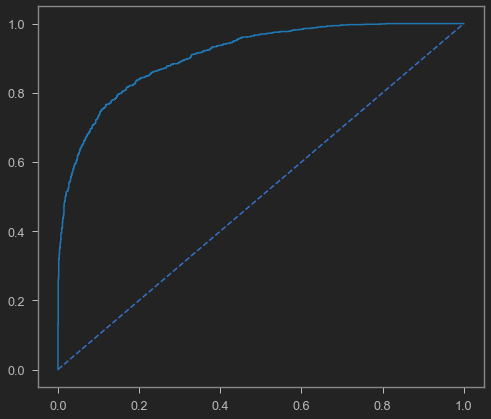

Wall time: 21.6 s


In [26]:
%%time
# gradient boosting tree model hyper-tuned

XGB = XGBClassifier()
params = {
        'max_depth': [n for n in range(6, 10, 2)]
            }

XGB_model = GridSearchCV(XGB, param_grid = params, cv = 7, n_jobs = -1)
XGB_model.fit(x_train, y_train)
print("Best Hyper Parameters:", XGB_model.best_params_)

# Area under the curve probability score
XGB_probs = XGB_model.predict_proba(x_test)
XGB_probs = XGB_probs[:, 1]
XGB_auc = roc_auc_score(y_test, XGB_probs)
print('AUC: %.3f' % XGB_auc)

XGB_predictions = XGB_model.predict(x_test)
XGB_accuracy = accuracy_score(y_test, XGB_predictions)
print("XGB accuracy: " + '%.3f' % XGB_accuracy)

# AUC plot
XGB_fpr, XGB_tpr, XGB_thresholds = roc_curve(y_test, XGB_probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(XGB_fpr, XGB_tpr, color = 'tab:blue')
plt.show()

In [27]:
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# The recall is intuitively the ability of the classifier to find all the positive samples.
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
print("GBT", classification_report(y_test, GBT_predictions))
print("-"*100)
print("RF", classification_report(y_test, RF_predictions))
print("-"*100)
print("XGB", classification_report(y_test, XGB_predictions))

GBT               precision    recall  f1-score   support

           0       0.91      0.95      0.93      1637
           1       0.91      0.84      0.87      1000

    accuracy                           0.91      2637
   macro avg       0.91      0.90      0.90      2637
weighted avg       0.91      0.91      0.91      2637

----------------------------------------------------------------------------------------------------
RF               precision    recall  f1-score   support

           0       0.76      0.81      0.78      1637
           1       0.65      0.58      0.61      1000

    accuracy                           0.72      2637
   macro avg       0.71      0.69      0.70      2637
weighted avg       0.72      0.72      0.72      2637

----------------------------------------------------------------------------------------------------
XGB               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1637
           1       0.83 

AUC scores :
Random Forest - 0.790
Gradient Boosting Classifier - 0.962
XGBoost Classifier - 0.908


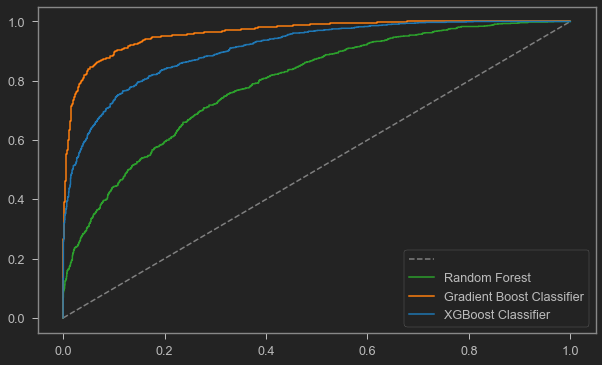

In [28]:
# Area under the curve probability score
b = '\033[1m'
ub = '\033[0m'

plt.figure(figsize=[10,6])
print(b + 'AUC scores :')
print(ub + 'Random Forest - ' + b +  '%.3f' % RF_auc)
print(ub + 'Gradient Boosting Classifier - ' + b +  '%.3f' % GBT_auc)
print(ub + 'XGBoost Classifier - ' + b +  '%.3f' % XGB_auc)

# AUC plot
plt.plot([0, 1], [0, 1], linestyle='--', color = 'grey')
plt.plot(RF_fpr, RF_tpr, color = 'tab:green')
plt.plot(GBT_fpr, GBT_tpr, color = 'tab:orange')
plt.plot(XGB_fpr, XGB_tpr, color = 'tab:blue')

plt.legend(('',
            'Random Forest', 
            'Gradient Boost Classifier',
            'XGBoost Classifier'
           ))
plt.show()

Random Forest accuracy: 0.723
Gradient Boosting accuracy: 0.908
XGB accuracy: 0.835


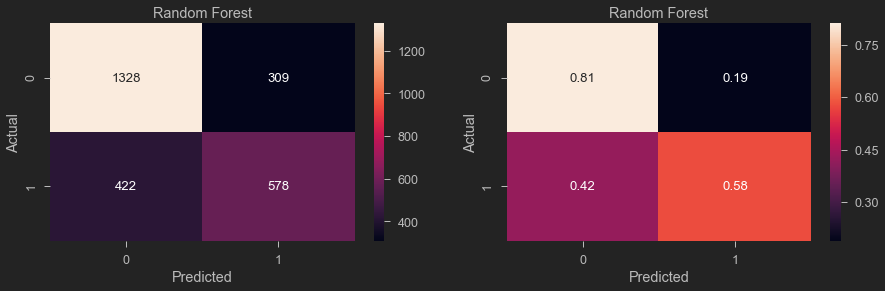

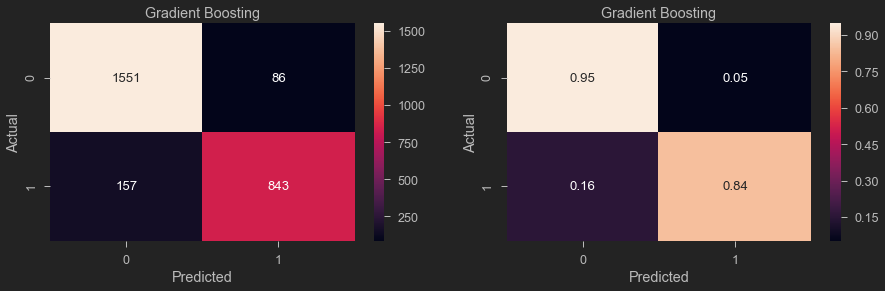

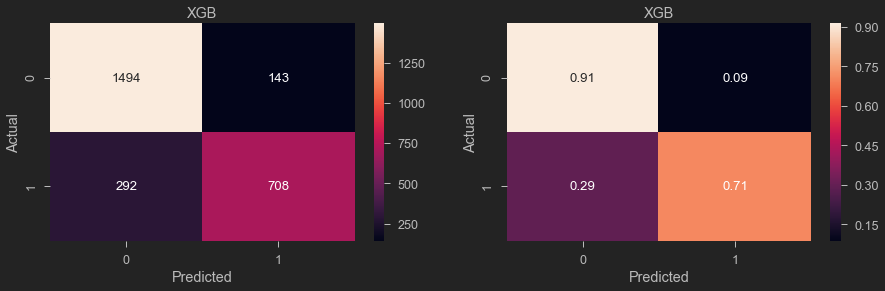

In [29]:
def conf_matrix(x, y):
    prediction = x.predict(x_test)
    CM_abs = confusion_matrix(y_test, prediction)
    CM_rel = confusion_matrix(y_test, prediction, normalize = 'true')

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    sns.heatmap(CM_abs, annot = True, fmt='d', ax = ax1)
    ax1.set(xlabel='Predicted', ylabel='Actual')
    ax1.set_title(y)
    
    sns.heatmap(CM_rel, annot = True, fmt='.2f', ax = ax2);
    ax2.set(xlabel='Predicted', ylabel='Actual')
    ax2.set_title(y)

    pred = accuracy_score(y_test, prediction)
    print(y + " accuracy: %.3f" % pred)
    
    
conf_matrix(RF_model, 'Random Forest')  
conf_matrix(GBT_model, 'Gradient Boosting')  
conf_matrix(XGB_model, 'XGB')  